# Mosquito Species Classification (MSC)
This code is complementary to the paper: HumBugDB: a large-scale acoustic mosquito dataset. Section B of `/docs/` gives detail on the meaning of the metadata fields that are present in the `csv` file `config.data_df`, while Section C describes in more detail the models used here as baselines.

This notebook provides the interface to partition data, extract features, train a BNN model in and evaluate its accuracy, precision-recall, confusion matrices and uncertainty metrics. Settings are specified in `config.py` and `config_pytorch.py` or `config_keras.py` which are located in `../lib`. Functions are imported from data and feature processing code in `../lib/feat_util.py`, model training in `../lib/runTorchMultiClass.py` or `../lib/runKeras.py` and evaluation in `../lib/evaluate.py`.

### Data and feature configuration `config.py`
Specify the metadata (csv) location in `data_df`, with the location of the raw wave files in `data_dir`. The desired output for the features is set by `dir_out`. Model objects will be saved to `../models/PyTorch/`.

### The feature
The feature extraction uses log-mel features with `librosa`, configurable in `config.py` with the sample rate `rate`, to which data is re-sampled on loading, a window size `win_size` which determines the size of a training window (in number of _feature_ windows), `step_size`, which determines the step size taken by the window, `NFFT`, and `n_hop`, which are parameters for the core STFT transform upon which log-mel feature extraction is based. Finally, `n_feat` determines the number of mel-frequency bands.

In `librosa`, we can calculate the value of `win_size` to achieve a user's desired `duration` for a label as follows:

`win_size` = `duration` / `frame_duration`, where `frame_duration` = `n_hop`/`rate`. Librosa uses a default `hop_length` of `NFFT/4`.
The default values in `config.py` are optimised for `rate` = 8000 with  `win_size` = 30, `NFFT` = 2048, `n_hop` = `default`,  to achieve a label duration of $30 \times 2048/(4\times 8000) = 1.92$ (s).

In [1]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results_multiclass
from feat_util import get_train_test_multispecies, reshape_feat
from PyTorch.runTorchMultiClass import (train_model, load_model, evaluate_model)


## Data selection & get features

In [2]:
df = pd.read_csv(config.data_df)
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus']

In [3]:
# if the pickle already exists, the loading time can be negligible

random_seed = 42
X_train, y_train, X_test, y_test = get_train_test_multispecies(df_all, classes, random_seed)

## Model training

In [4]:
X_train_CNN, y_train_CNN = reshape_feat(X_train, y_train, config.win_size, config.step_size)

In [5]:
# from sklearn.utils import class_weight

# Choose from {ResnetDropoutFull, Resnet, VGGishDropout} as defined in runTorchMulticlass.py

# class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train)),y=np.array(y_train))
# class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
# model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights, model = ResnetDropoutFull(n_classes = 8, dropout=0.2))
# model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights)

model = train_model(X_train_CNN, y_train_CNN)

Training on cuda:0
all_y all_y_pred (78745, 1) (78745,)
Saving model to: ..\outputs\models\pytorch\model_e0_2024_07_13_20_18_58.pth
Epoch: 0, Train Loss: 0.68908407, Train Acc: 0.75340657, overrun_counter 0


KeyboardInterrupt: 

## Model evaluation

Training on cuda:0
Evaluating on cuda:0


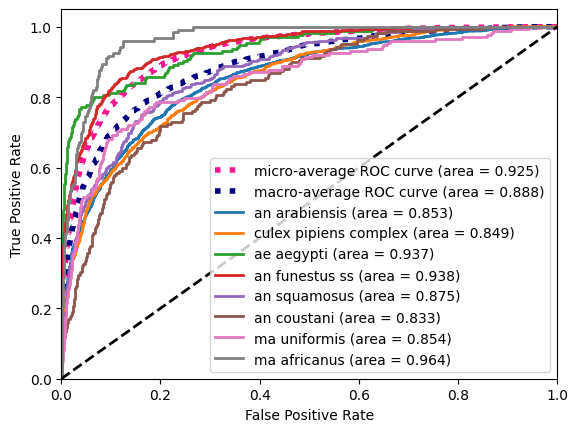

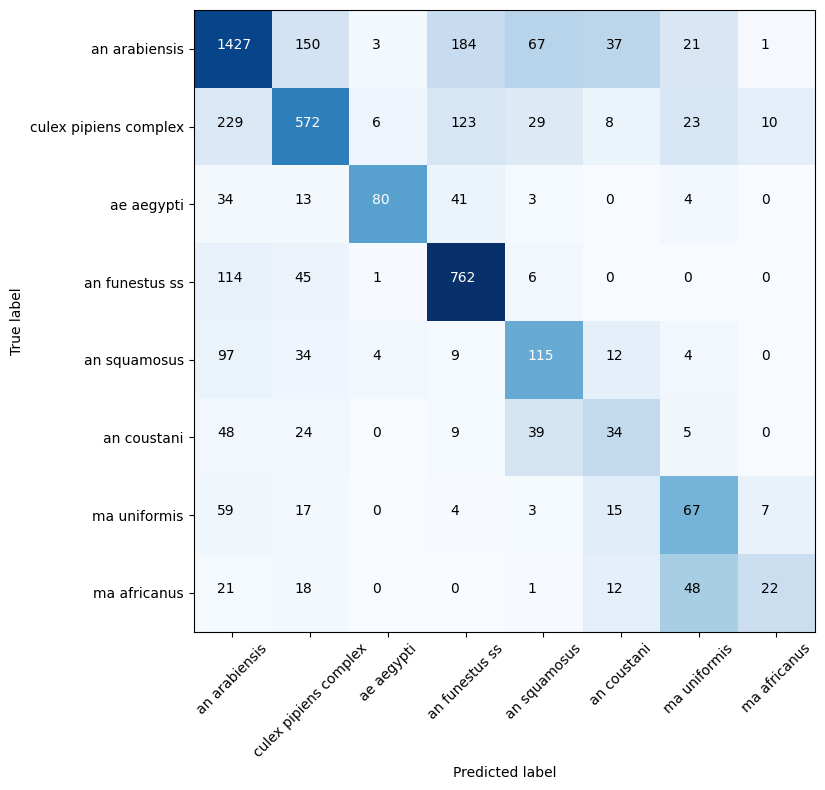

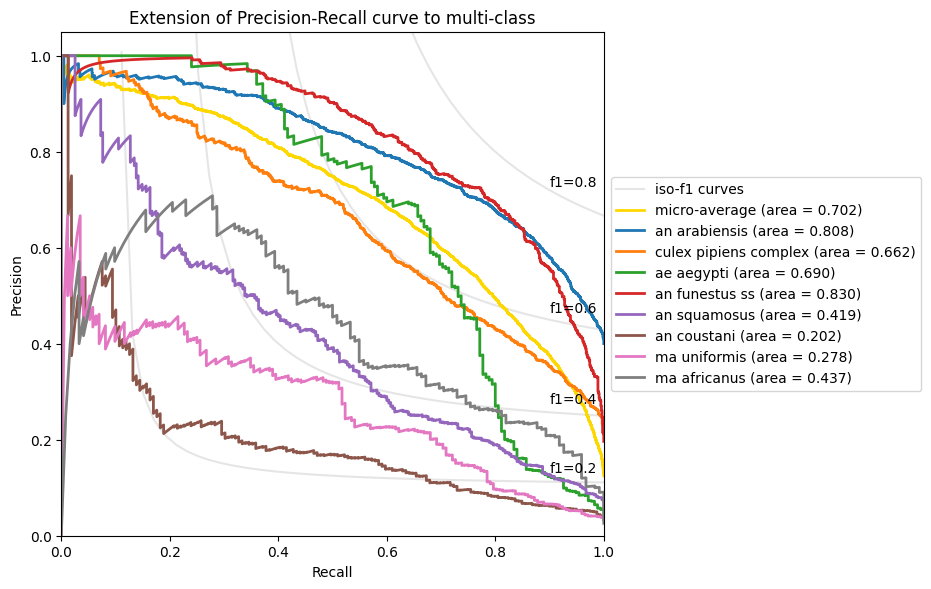

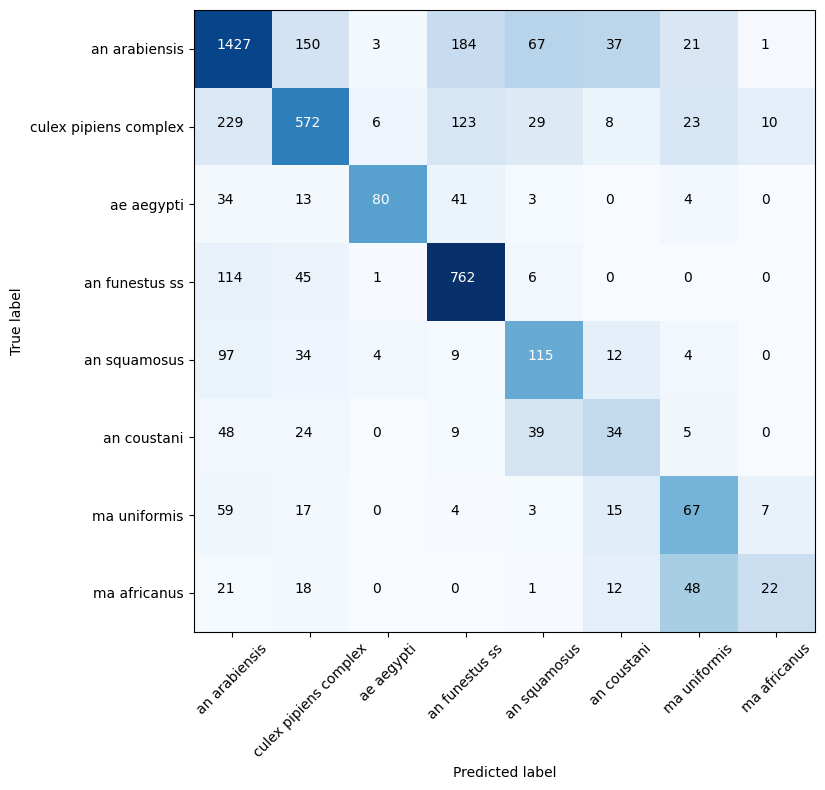

In [6]:
filepath = '../outputs/models/pytorch/'
model_name = 'model_e0_2024_07_13_20_18_58.pth'  

model = load_model(filepath + model_name)

X_test_CNN, y_test_CNN = reshape_feat(X_test, y_test, config.win_size, config.win_size)
preds_list = evaluate_model(model, X_test_CNN, y_test_CNN, 100)  # Predict directly over feature windows (1.92 s)
get_results_multiclass(y_test_CNN, np.mean(preds_list,axis=0), '_seed_' + str(random_seed) +
                                 '_'+ model_name, classes)